# Import the libraries and the data

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
import tensorflow as tf

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

print(df.shape)
df.head()

(48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# Definition of required functions

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [5]:
def univariate_data_prep_function(dataset, start, end, window, horizon):
    '''
    Prepare univariate data that is suitable for a time series
    
    Args:
        dataset (float64): Scaled values for the dependent variable, numpy array of floats 
        start (int): Start point of range, integer
        end (int): End point of range, integer
        window (int): Number of units to be viewed per step, integer
        horizon (int): Number of units to be predicted, integer
    
    Returns:
        X (float64): Generated X-values for each step, numpy array of floats
        y (float64): Generated y-values for each step, numpy array of floats
    '''   
    X = []
    y = []

    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indicesx = range(i-window, i)
        X.append(np.reshape(dataset[indicesx], (window, 1)))
        indicesy = range(i,i+horizon)
        y.append(dataset[indicesy])
    return np.array(X), np.array(y)

# Data pre-processing

## Drop Duplicates

In [6]:
df = df.drop_duplicates(subset=['date_time'], keep=False)

df.shape

(35130, 9)

## Generate Test Set

In [7]:
test_data = df['traffic_volume'].tail(10)

df = df.drop(df['traffic_volume'].tail(10).index)

df.shape

(35120, 9)

## Define Target Variable

In [8]:
uni_data = df['traffic_volume']
uni_data.index = df['date_time']
uni_data.head()

date_time
2012-10-02 09:00:00    5545
2012-10-02 10:00:00    4516
2012-10-02 11:00:00    4767
2012-10-02 12:00:00    5026
2012-10-02 13:00:00    4918
Name: traffic_volume, dtype: int64

## Scaling

In [9]:
uni_data = uni_data.values
scaler_x = preprocessing.MinMaxScaler()
x_scaled = scaler_x.fit_transform(uni_data.reshape(-1, 1))

## Train-Validation Split

### for Single Step Style (sss)

In [10]:
univar_hist_window_sss = 48
horizon_sss = 1
train_split_sss = 30000

x_train_uni_sss, y_train_uni_sss = univariate_data_prep_function(x_scaled, 0, train_split_sss, 
                                                                 univar_hist_window_sss, horizon_sss)

x_val_uni_sss, y_val_uni_sss = univariate_data_prep_function(x_scaled, train_split_sss, None, 
                                                             univar_hist_window_sss, horizon_sss)

In [11]:
print ('Length of first Single Window:')
print (len(x_train_uni_sss[0]))
print()
print ('Target horizon:')
print (y_train_uni_sss[0])

Length of first Single Window:
48

Target horizon:
[[0.71126374]]


### for Horizon Style (hs)

In [12]:
univar_hist_window_hs = 48
horizon_hs = 10
train_split_hs = 30000

x_train_uni_hs, y_train_uni_hs = univariate_data_prep_function(x_scaled, 0, train_split_hs, 
                                                               univar_hist_window_hs, horizon_hs)

x_val_uni_hs, y_val_uni_hs = univariate_data_prep_function(x_scaled, train_split_hs, None, 
                                                           univar_hist_window_hs, horizon_hs)

In [13]:
print ('Length of first Single Window:')
print (len(x_train_uni_hs[0]))
print()
print ('Target horizon:')
print (y_train_uni_hs[0])

Length of first Single Window:
48

Target horizon:
[[0.71126374]
 [0.75563187]
 [0.78475275]
 [0.86428571]
 [0.83200549]
 [0.67403846]
 [0.48118132]
 [0.41717033]
 [0.38763736]
 [0.27362637]]


## Prepare training and test data using tf

### for Single Step Style (sss)

In [14]:
BATCH_SIZE_sss = 256
BUFFER_SIZE_sss = 150

train_univariate_sss = tf.data.Dataset.from_tensor_slices((x_train_uni_sss, y_train_uni_sss))
train_univariate_sss = train_univariate_sss.cache().shuffle(BUFFER_SIZE_sss).batch(BATCH_SIZE_sss).repeat()

validation_univariate_sss = tf.data.Dataset.from_tensor_slices((x_val_uni_sss, y_val_uni_sss))
validation_univariate_sss = validation_univariate_sss.batch(BATCH_SIZE_sss).repeat()

### for Horizon Style (hs)

In [15]:
BATCH_SIZE_hs = 256
BUFFER_SIZE_hs = 150

train_univariate_hs = tf.data.Dataset.from_tensor_slices((x_train_uni_hs, y_train_uni_hs))
train_univariate_hs = train_univariate_hs.cache().shuffle(BUFFER_SIZE_hs).batch(BATCH_SIZE_hs).repeat()

validation_univariate_hs = tf.data.Dataset.from_tensor_slices((x_val_uni_hs, y_val_uni_hs))
validation_univariate_hs = validation_univariate_hs.batch(BATCH_SIZE_hs).repeat()

# Neural Networks

Calculation of the steps:

+ n_steps_per_epoch: len(df) / batch_size
+ n_validation_steps: len(df) / batch_size 

In [16]:
n_steps_per_epoch = 117
n_validation_steps = 20
n_epochs = 100

## LSTM

### Single Step Style

**Define Layer Structure**

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni_sss.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_sss)])

model.compile(loss='mse',
              optimizer='adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 48, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


**Fit the model**

In [19]:
model_path = 'model/lstm_model_sss.h5'

In [20]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [21]:
history = model.fit(train_univariate_sss, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_sss, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 18s 130ms/step - loss: 0.0942 - val_loss: 0.0345
Epoch 2/100
117/117 [==============================] - 15s 124ms/step - loss: 0.0355 - val_loss: 0.0238
Epoch 3/100
117/117 [==============================] - 14s 122ms/step - loss: 0.0258 - val_loss: 0.0135
Epoch 4/100
117/117 [==============================] - 14s 124ms/step - loss: 0.0180 - val_loss: 0.0115
Epoch 5/100
117/117 [==============================] - 14s 118ms/step - loss: 0.0162 - val_loss: 0.0111
Epoch 6/100
117/117 [==============================] - 13s 114ms/step - loss: 0.0156 - val_loss: 0.0110
Epoch 7/100
117/117 [==============================] - 14s 123ms/step - loss: 0.0152 - val_loss: 0.0107
Epoch 8/100
117/117 [==============================] - 14s 116ms/step - loss: 0.0148 - val_loss: 0.0103
Epoch 9/100
117/117 [==============================] - 12s 107ms/step - loss: 0.0145 - val_loss: 0.0101
Epoch 10/100
117/117 [==============================] - 14s 118m

117/117 [==============================] - 12s 104ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 80/100
117/117 [==============================] - 13s 110ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 81/100
117/117 [==============================] - 13s 115ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 82/100
117/117 [==============================] - 15s 127ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 83/100
117/117 [==============================] - 13s 112ms/step - loss: 0.0089 - val_loss: 0.0067
Epoch 84/100
117/117 [==============================] - 14s 120ms/step - loss: 0.0088 - val_loss: 0.0067
Epoch 85/100
117/117 [==============================] - 13s 112ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 86/100
117/117 [==============================] - 13s 109ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 87/100
117/117 [==============================] - 15s 125ms/step - loss: 0.0088 - val_loss: 0.0067
Epoch 88/100
117/117 [==============================] - 15s 128ms/st

**Validate the model**

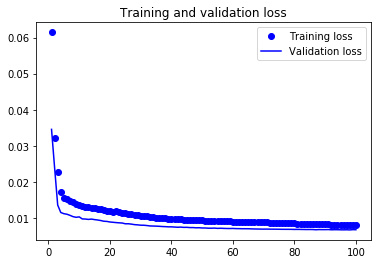

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [23]:
trained_lstm_model_sss = tf.keras.models.load_model(model_path)

In [24]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_sss)
test_history = test_horizon.values

result = []
# Define Forecast length here
window_len = len(test_data)
test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))

for i in range(1, window_len+1): 
    test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))
    
    # Inserting the model
    predicted_results = trained_lstm_model_sss.predict(test_scaled)
    
    print(f'predicted : {predicted_results}')
    result.append(predicted_results[0])
    test_scaled = np.append(test_scaled[:,1:],[[predicted_results]])

predicted : [[0.63438505]]
predicted : [[0.63533115]]
predicted : [[0.634082]]
predicted : [[0.63566756]]
predicted : [[0.6329583]]
predicted : [[0.613764]]
predicted : [[0.5683779]]
predicted : [[0.49576783]]
predicted : [[0.4103733]]
predicted : [[0.32943153]]


In [25]:
result_inv_trans = scaler_x.inverse_transform(result)
result_inv_trans

array([[4048.05569381],
       [4053.5932436 ],
       [4046.28205913],
       [4055.56224322],
       [4039.7048887 ],
       [3927.36062187],
       [3661.7159192 ],
       [3236.72911954],
       [2736.91492674],
       [2263.16276741]])

In [26]:
timeseries_evaluation_metrics_func(test_data, result_inv_trans)

MSE is : 591399.1955569341
MAE is : 621.9095003694296
RMSE is : 769.0248341613775
MAPE is : 62.18672314557021
R2 is : 0.616054740542708



In [27]:
rmse_lstm_model_sss = np.sqrt(metrics.mean_squared_error(test_data, result_inv_trans))

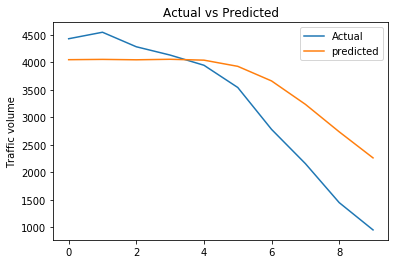

In [28]:
plt.plot(list(test_data))
plt.plot(list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

### Horizon Style

**Define Layer Structure**

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni_hs.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_hs)])

model.compile(loss='mse',
              optimizer='adam')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 71,510
Trainable params: 71,510
Non-trainable params: 0
_________________________________________________________________


**Fit the model**

In [31]:
model_path = 'model/lstm_model_hs.h5'

In [32]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [33]:
history = model.fit(train_univariate_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 17s 123ms/step - loss: 0.1156 - val_loss: 0.0555
Epoch 2/100
117/117 [==============================] - 15s 132ms/step - loss: 0.0589 - val_loss: 0.0484
Epoch 3/100
117/117 [==============================] - 14s 119ms/step - loss: 0.0538 - val_loss: 0.0441
Epoch 4/100
117/117 [==============================] - 15s 127ms/step - loss: 0.0507 - val_loss: 0.0398
Epoch 5/100
117/117 [==============================] - 16s 139ms/step - loss: 0.0483 - val_loss: 0.0380
Epoch 6/100
117/117 [==============================] - 13s 112ms/step - loss: 0.0463 - val_loss: 0.0363
Epoch 7/100
117/117 [==============================] - 13s 115ms/step - loss: 0.0448 - val_loss: 0.0346
Epoch 8/100
117/117 [==============================] - 14s 116ms/step - loss: 0.0432 - val_loss: 0.0336
Epoch 9/100
117/117 [==============================] - 15s 130ms/step - loss: 0.0421 - val_loss: 0.0326
Epoch 10/100
117/117 [==============================] - 17s 148m

117/117 [==============================] - 14s 120ms/step - loss: 0.0242 - val_loss: 0.0225
Epoch 80/100
117/117 [==============================] - 16s 136ms/step - loss: 0.0244 - val_loss: 0.0225
Epoch 81/100
117/117 [==============================] - 14s 121ms/step - loss: 0.0239 - val_loss: 0.0227
Epoch 82/100
117/117 [==============================] - 14s 116ms/step - loss: 0.0236 - val_loss: 0.0223
Epoch 83/100
117/117 [==============================] - 15s 127ms/step - loss: 0.0236 - val_loss: 0.0228
Epoch 84/100
117/117 [==============================] - 14s 121ms/step - loss: 0.0233 - val_loss: 0.0231
Epoch 85/100
117/117 [==============================] - 14s 122ms/step - loss: 0.0231 - val_loss: 0.0229
Epoch 86/100
117/117 [==============================] - 16s 133ms/step - loss: 0.0228 - val_loss: 0.0229
Epoch 87/100
117/117 [==============================] - 14s 121ms/step - loss: 0.0226 - val_loss: 0.0230
Epoch 88/100
117/117 [==============================] - 13s 115ms/st

**Validate the model**

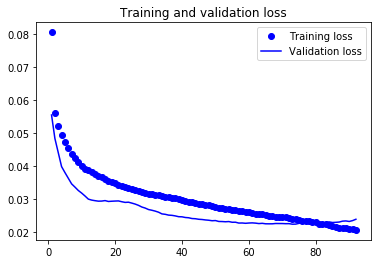

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [35]:
trained_lstm_model_hs = tf.keras.models.load_model(model_path)

In [36]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))
test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))

# Inserting the model
predicted_results = trained_lstm_model_hs.predict(test_scaled)
predicted_results

array([[0.6260904 , 0.6293826 , 0.6134758 , 0.59348387, 0.5574149 ,
        0.5033061 , 0.4394251 , 0.37882045, 0.3272102 , 0.2887445 ]],
      dtype=float32)

In [37]:
predicted_inv_trans = scaler_x.inverse_transform(predicted_results)
predicted_inv_trans

array([[3999.507 , 4018.7764, 3925.6738, 3808.6611, 3597.5493, 3280.8506,
        2906.955 , 2552.236 , 2250.1611, 2025.0216]], dtype=float32)

In [38]:
timeseries_evaluation_metrics_func(test_data, predicted_inv_trans[0])

MSE is : 284439.69056123646
MAE is : 464.0355590820312
RMSE is : 533.3288765492043
MAPE is : 24.392792726600234
R2 is : 0.8153374715201618



In [39]:
rmse_lstm_model_hs = np.sqrt(metrics.mean_squared_error(test_data, predicted_inv_trans[0]))

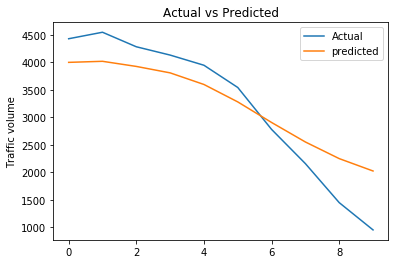

In [40]:
plt.plot(list(test_data))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Bidirectional LSTM

### Single Step Style

**Define Layer Structure**

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                                  input_shape=x_train_uni_sss.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_sss)])

model.compile(loss='mse',
              optimizer='adam')

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 184,041
Trainable params: 184,041
Non-trainable params: 0
_________________________________________________________________


**Fit the model**

In [43]:
model_path = 'model/bi_lstm_model_sss.h5'

In [44]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [45]:
history = model.fit(train_univariate_sss, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_sss, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 49s 369ms/step - loss: 0.0966 - val_loss: 0.0731
Epoch 2/100
117/117 [==============================] - 50s 428ms/step - loss: 0.0728 - val_loss: 0.0221
Epoch 3/100
117/117 [==============================] - 45s 387ms/step - loss: 0.0280 - val_loss: 0.0154
Epoch 4/100
117/117 [==============================] - 51s 436ms/step - loss: 0.0217 - val_loss: 0.0146
Epoch 5/100
117/117 [==============================] - 52s 447ms/step - loss: 0.0192 - val_loss: 0.0135
Epoch 6/100
117/117 [==============================] - 47s 403ms/step - loss: 0.0180 - val_loss: 0.0131
Epoch 7/100
117/117 [==============================] - 50s 430ms/step - loss: 0.0171 - val_loss: 0.0121
Epoch 8/100
117/117 [==============================] - 48s 409ms/step - loss: 0.0167 - val_loss: 0.0123
Epoch 9/100
117/117 [==============================] - 51s 432ms/step - loss: 0.0163 - val_loss: 0.0120
Epoch 10/100
117/117 [==============================] - 52s 448m

**Validate the model**

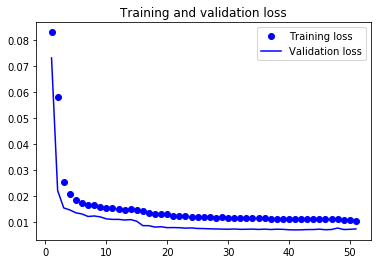

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [47]:
trained_bi_lstm_model_sss = tf.keras.models.load_model(model_path)

In [48]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_sss)
test_history = test_horizon.values

result = []
# Define Forecast length here
window_len = len(test_data)
test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))

for i in range(1, window_len+1):
    
    test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))
    
    # Inserting the model
    predicted_results = trained_bi_lstm_model_sss.predict(test_scaled)
    
    print(f'predicted : {predicted_results}')
    result.append(predicted_results[0])
    test_scaled = np.append(test_scaled[:,1:],[[predicted_results]])

predicted : [[0.65958625]]
predicted : [[0.6638803]]
predicted : [[0.6558111]]
predicted : [[0.65843725]]
predicted : [[0.66241646]]
predicted : [[0.6514476]]
predicted : [[0.62076354]]
predicted : [[0.5616572]]
predicted : [[0.47837794]]
predicted : [[0.40990025]]


In [49]:
result_inv_trans = scaler_x.inverse_transform(result)
result_inv_trans

array([[4195.55832583],
       [4220.69132918],
       [4173.46220088],
       [4188.83323622],
       [4212.12352943],
       [4147.92276865],
       [3968.32900119],
       [3622.37953496],
       [3134.9460727 ],
       [2734.14615184]])

In [50]:
timeseries_evaluation_metrics_func(test_data, result_inv_trans)

MSE is : 1017161.6362175249
MAE is : 771.1968439102172
RMSE is : 1008.544315445546
MAPE is : 66.03169019553141
R2 is : 0.3396433555176447



In [51]:
rmse_bi_lstm_model_sss = np.sqrt(metrics.mean_squared_error(test_data, result_inv_trans))

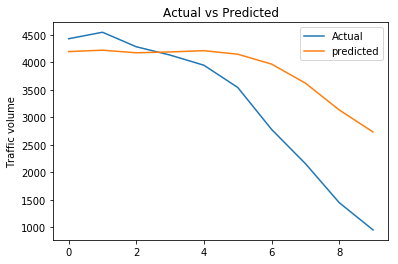

In [52]:
plt.plot(list(test_data))
plt.plot(list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

### Horizon Style

**Define Layer Structure**

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True), 
                                  input_shape=x_train_uni_hs.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='softmax'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_hs)])

model.compile(loss='mse',
              optimizer='adam')

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 48, 200)           81600     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
Total params: 184,230
Trainable params: 184,230
Non-trainable params: 0
_________________________________________________________________


**Fit the model**

In [55]:
model_path = 'model/bi_lstm_model_hs.h5'

In [56]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [57]:
history = model.fit(train_univariate_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 63s 487ms/step - loss: 0.1830 - val_loss: 0.0970
Epoch 2/100
117/117 [==============================] - 54s 466ms/step - loss: 0.0910 - val_loss: 0.0725
Epoch 3/100
117/117 [==============================] - 56s 482ms/step - loss: 0.0782 - val_loss: 0.0660
Epoch 4/100
117/117 [==============================] - 60s 509ms/step - loss: 0.0737 - val_loss: 0.0621
Epoch 5/100
117/117 [==============================] - 53s 452ms/step - loss: 0.0697 - val_loss: 0.0589
Epoch 6/100
117/117 [==============================] - 61s 524ms/step - loss: 0.0663 - val_loss: 0.0554
Epoch 7/100
117/117 [==============================] - 58s 492ms/step - loss: 0.0616 - val_loss: 0.0491
Epoch 8/100
117/117 [==============================] - 59s 507ms/step - loss: 0.0561 - val_loss: 0.0485
Epoch 9/100
117/117 [==============================] - 59s 501ms/step - loss: 0.0554 - val_loss: 0.0402
Epoch 10/100
117/117 [==============================] - 52s 441m

**Validate the model**

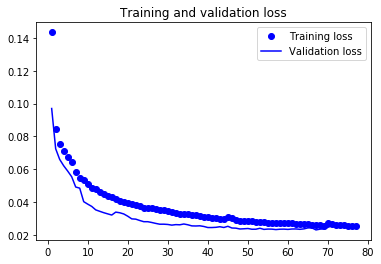

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [59]:
trained_bi_lstm_model_hs = tf.keras.models.load_model(model_path)

In [60]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))
test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))

# Inserting the model
predicted_results = trained_bi_lstm_model_hs.predict(test_scaled)
predicted_results

array([[0.63119113, 0.6338015 , 0.6221781 , 0.6095376 , 0.59628034,
        0.57363194, 0.5343294 , 0.4838582 , 0.4357484 , 0.39525127]],
      dtype=float32)

In [61]:
predicted_inv_trans = scaler_x.inverse_transform(predicted_results)
predicted_inv_trans

array([[4029.3616, 4044.6401, 3976.6082, 3902.6235, 3825.0288, 3692.4678,
        3462.43  , 3167.0222, 2885.4353, 2648.4058]], dtype=float32)

In [62]:
timeseries_evaluation_metrics_func(test_data, predicted_inv_trans[0])

MSE is : 700772.4352698624
MAE is : 652.8498779296875
RMSE is : 837.12151762445
MAPE is : 38.7883749188566
R2 is : 0.5450479870422762



In [63]:
rmse_bi_lstm_model_hs = np.sqrt(metrics.mean_squared_error(test_data, predicted_inv_trans[0]))

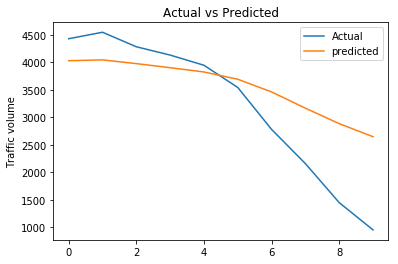

In [64]:
plt.plot(list(test_data))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## GRU

### Single Step Style

**Define Layer Structure**

In [65]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni_sss.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_sss)])

model.compile(loss='mse',
              optimizer='adam')

In [66]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 48, 100)           30900     
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________


**Fit the model**

In [67]:
model_path = 'model/gru_model_sss.h5'

In [68]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [69]:
history = model.fit(train_univariate_sss, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_sss, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 36s 278ms/step - loss: 0.0730 - val_loss: 0.0194
Epoch 2/100
117/117 [==============================] - 27s 228ms/step - loss: 0.0218 - val_loss: 0.0135
Epoch 3/100
117/117 [==============================] - 28s 237ms/step - loss: 0.0177 - val_loss: 0.0127
Epoch 4/100
117/117 [==============================] - 28s 241ms/step - loss: 0.0164 - val_loss: 0.0118
Epoch 5/100
117/117 [==============================] - 29s 245ms/step - loss: 0.0152 - val_loss: 0.0109
Epoch 6/100
117/117 [==============================] - 27s 228ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 7/100
117/117 [==============================] - 27s 230ms/step - loss: 0.0144 - val_loss: 0.0104
Epoch 8/100
117/117 [==============================] - 29s 246ms/step - loss: 0.0141 - val_loss: 0.0101
Epoch 9/100
117/117 [==============================] - 28s 242ms/step - loss: 0.0140 - val_loss: 0.0101
Epoch 10/100
117/117 [==============================] - 27s 231m

117/117 [==============================] - 28s 240ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 80/100
117/117 [==============================] - 26s 224ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 81/100
117/117 [==============================] - 27s 227ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 82/100
117/117 [==============================] - 27s 233ms/step - loss: 0.0090 - val_loss: 0.0070
Epoch 83/100
117/117 [==============================] - 27s 231ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 84/100
117/117 [==============================] - 27s 234ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 85/100
117/117 [==============================] - 26s 225ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 86/100
117/117 [==============================] - 28s 238ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 87/100
117/117 [==============================] - 25s 217ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 88/100
117/117 [==============================] - 27s 230ms/st

**Validate the model**

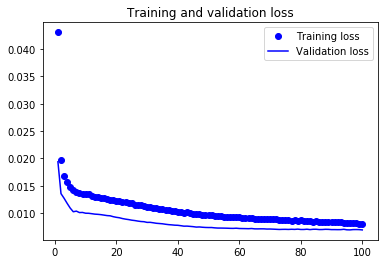

In [70]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [71]:
trained_gru_model_sss = tf.keras.models.load_model(model_path)

In [72]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_sss)
test_history = test_horizon.values

result = []
# Define Forecast length here
window_len = len(test_data)
test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))

for i in range(1, window_len+1):
    
    test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))
    
    # Inserting the model
    predicted_results = trained_gru_model_sss.predict(test_scaled)
    
    print(f'predicted : {predicted_results}')
    result.append(predicted_results[0])
    test_scaled = np.append(test_scaled[:,1:],[[predicted_results]])

predicted : [[0.65305144]]
predicted : [[0.64872515]]
predicted : [[0.6423526]]
predicted : [[0.6483784]]
predicted : [[0.6514243]]
predicted : [[0.6337963]]
predicted : [[0.6005938]]
predicted : [[0.56267494]]
predicted : [[0.52256966]]
predicted : [[0.47509766]]


In [73]:
result_inv_trans = scaler_x.inverse_transform(result)
result_inv_trans

array([[4157.3100546 ],
       [4131.98831475],
       [4094.68965673],
       [4129.95861244],
       [4147.78636205],
       [4044.6095956 ],
       [3850.2755425 ],
       [3628.33642167],
       [3393.60019875],
       [3115.74658203]])

In [74]:
timeseries_evaluation_metrics_func(test_data, result_inv_trans)

MSE is : 1232647.2150865484
MAE is : 822.3408064067364
RMSE is : 1110.2464659194138
MAPE is : 65.4188800991261
R2 is : 0.19974687424113757



In [75]:
rmse_gru_model_sss = np.sqrt(metrics.mean_squared_error(test_data, result_inv_trans))

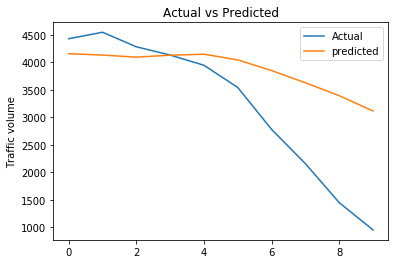

In [76]:
plt.plot(list(test_data))
plt.plot(list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

### Horizon Style

**Define Layer Structure**

In [77]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_uni_hs.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_hs)])

model.compile(loss='mse',
              optimizer='adam')

In [78]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 48, 100)           30900     
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 100)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
Total params: 54,210
Trainable params: 54,210
Non-trainable params: 0
_________________________________________________________________


**Fit the model**

In [79]:
model_path = 'model/gru_model_hs.h5'

In [80]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [81]:
history = model.fit(train_univariate_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 37s 289ms/step - loss: 0.1330 - val_loss: 0.0649
Epoch 2/100
117/117 [==============================] - 31s 262ms/step - loss: 0.0600 - val_loss: 0.0436
Epoch 3/100
117/117 [==============================] - 32s 270ms/step - loss: 0.0511 - val_loss: 0.0370
Epoch 4/100
117/117 [==============================] - 33s 278ms/step - loss: 0.0470 - val_loss: 0.0343
Epoch 5/100
117/117 [==============================] - 31s 266ms/step - loss: 0.0445 - val_loss: 0.0327
Epoch 6/100
117/117 [==============================] - 31s 267ms/step - loss: 0.0430 - val_loss: 0.0314
Epoch 7/100
117/117 [==============================] - 31s 268ms/step - loss: 0.0419 - val_loss: 0.0308
Epoch 8/100
117/117 [==============================] - 31s 264ms/step - loss: 0.0410 - val_loss: 0.0302
Epoch 9/100
117/117 [==============================] - 32s 275ms/step - loss: 0.0404 - val_loss: 0.0300
Epoch 10/100
117/117 [==============================] - 33s 278m

**Validate the model**

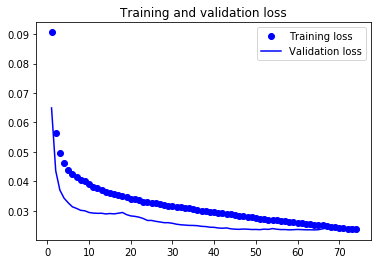

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [83]:
trained_gru_model_hs = tf.keras.models.load_model(model_path)

In [84]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))
test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))

# Inserting the model
predicted_results = trained_gru_model_hs.predict(test_scaled)
predicted_results

array([[0.6430253 , 0.62971675, 0.61815035, 0.608606  , 0.5834916 ,
        0.53887445, 0.483938  , 0.43199947, 0.3802234 , 0.32326838]],
      dtype=float32)

In [85]:
predicted_inv_trans = scaler_x.inverse_transform(predicted_results)
predicted_inv_trans

array([[4098.627 , 4020.7322, 3953.034 , 3897.1707, 3750.1765, 3489.032 ,
        3167.4893, 2863.493 , 2560.4475, 2227.0898]], dtype=float32)

In [86]:
timeseries_evaluation_metrics_func(test_data, predicted_inv_trans[0])

MSE is : 409131.42706679704
MAE is : 514.6747314453125
RMSE is : 639.6338226413586
MAPE is : 29.54886087472277
R2 is : 0.7343857193289486



In [87]:
rmse_gru_model_hs = np.sqrt(metrics.mean_squared_error(test_data, predicted_inv_trans[0]))

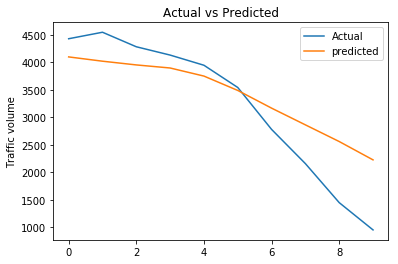

In [88]:
plt.plot(list(test_data))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Encoder Decoder LSTM

### Single Step Style

**Define Layer Structure**

In [89]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni_sss.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni_sss.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=horizon_sss))])

model.compile(loss='mse',
              optimizer='adam')

In [90]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 48, 100)           40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 48, 50)            30200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 15)                3960      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 15)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 100)            46400     
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 50)             30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)             

**Fit the model**

In [91]:
model_path = 'model/ed_lstm_model_sss.h5'

In [92]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [93]:
history = model.fit(train_univariate_sss, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_sss, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 40s 276ms/step - loss: 0.1376 - val_loss: 0.0740
Epoch 2/100
117/117 [==============================] - 29s 244ms/step - loss: 0.0763 - val_loss: 0.0736
Epoch 3/100
117/117 [==============================] - 29s 247ms/step - loss: 0.0739 - val_loss: 0.0371
Epoch 4/100
117/117 [==============================] - 29s 246ms/step - loss: 0.0299 - val_loss: 0.0120
Epoch 5/100
117/117 [==============================] - 28s 238ms/step - loss: 0.0131 - val_loss: 0.0096
Epoch 6/100
117/117 [==============================] - 28s 242ms/step - loss: 0.0118 - val_loss: 0.0097
Epoch 7/100
117/117 [==============================] - 30s 255ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 8/100
117/117 [==============================] - 27s 232ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 9/100
117/117 [==============================] - 29s 246ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 10/100
117/117 [==============================] - 28s 241m

117/117 [==============================] - 28s 238ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 80/100
117/117 [==============================] - 28s 242ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 81/100
117/117 [==============================] - 29s 250ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 82/100
117/117 [==============================] - 28s 240ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 83/100
117/117 [==============================] - 28s 243ms/step - loss: 0.0070 - val_loss: 0.0066
Epoch 84/100
117/117 [==============================] - 29s 244ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 85/100
117/117 [==============================] - 29s 251ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 86/100
117/117 [==============================] - 29s 246ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 87/100
117/117 [==============================] - 28s 236ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 88/100
117/117 [==============================] - 28s 237ms/st

**Validate the model**

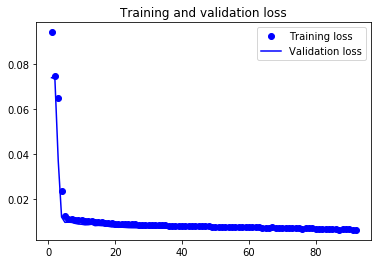

In [94]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [95]:
trained_ed_lstm_model_sss = tf.keras.models.load_model(model_path)

In [96]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_sss)
test_history = test_horizon.values

result = []
# Define Forecast length here
window_len = len(test_data)
test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))

for i in range(1, window_len+1):
    
    test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))
    
    # Inserting the model
    predicted_results = trained_ed_lstm_model_sss.predict(test_scaled)
    
    print(f'predicted : {predicted_results}')
    result.append(predicted_results[0])
    test_scaled = np.append(test_scaled[:,1:],[[predicted_results]])

predicted : [[[0.64883816]]]
predicted : [[[0.64051116]]]
predicted : [[[0.6244791]]]
predicted : [[[0.6232974]]]
predicted : [[[0.62396914]]]
predicted : [[[0.60752153]]]
predicted : [[[0.5700078]]]
predicted : [[[0.510002]]]
predicted : [[[0.43510813]]]
predicted : [[[0.37863362]]]


In [97]:
result_inv_trans = scaler_x.inverse_transform(np.array(result).reshape(-1,1))
result_inv_trans

array([[4132.65  ],
       [4083.9119],
       [3990.0762],
       [3983.1597],
       [3987.0913],
       [3890.8235],
       [3671.2556],
       [3320.0417],
       [2881.6877],
       [2551.1426]], dtype=float32)

In [98]:
timeseries_evaluation_metrics_func(test_data, result_inv_trans)

MSE is : 727398.7517876684
MAE is : 666.9244873046875
RMSE is : 852.8767506431797
MAPE is : 62.328608844902725
R2 is : 0.5277617815813544



In [99]:
rmse_ed_lstm_model_sss = np.sqrt(metrics.mean_squared_error(test_data, result_inv_trans))

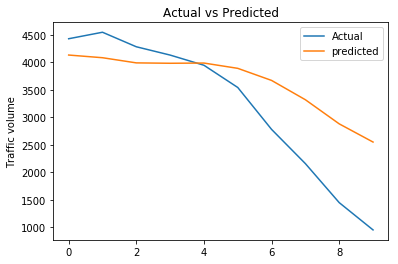

In [100]:
plt.plot(list(test_data))
plt.plot(list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

### Horizon Style

**Define Layer Structure**

In [101]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_uni_hs.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_uni_hs.shape[1]), 
    tf.keras.layers.LSTM(units=100,return_sequences=True),
    tf.keras.layers.LSTM(units=50,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))])

model.compile(loss='mse',
              optimizer='adam')

In [102]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 48, 100)           40800     
_________________________________________________________________
lstm_14 (LSTM)               (None, 48, 50)            30200     
_________________________________________________________________
lstm_15 (LSTM)               (None, 15)                3960      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 15)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 100)           46400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 10, 50)            30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 1)            

**Fit the model**

In [103]:
model_path = 'model/ed_lstm_model_hs.h5'

In [104]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [105]:
history = model.fit(train_univariate_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 38s 266ms/step - loss: 0.1230 - val_loss: 0.0568
Epoch 2/100
117/117 [==============================] - 29s 249ms/step - loss: 0.0582 - val_loss: 0.0590
Epoch 3/100
117/117 [==============================] - 29s 251ms/step - loss: 0.0543 - val_loss: 0.0506
Epoch 4/100
117/117 [==============================] - 28s 235ms/step - loss: 0.0506 - val_loss: 0.0442
Epoch 5/100
117/117 [==============================] - 30s 255ms/step - loss: 0.0476 - val_loss: 0.0408
Epoch 6/100
117/117 [==============================] - 29s 244ms/step - loss: 0.0449 - val_loss: 0.0390
Epoch 7/100
117/117 [==============================] - 28s 237ms/step - loss: 0.0433 - val_loss: 0.0376
Epoch 8/100
117/117 [==============================] - 28s 242ms/step - loss: 0.0420 - val_loss: 0.0369
Epoch 9/100
117/117 [==============================] - 28s 241ms/step - loss: 0.0407 - val_loss: 0.0373
Epoch 10/100
117/117 [==============================] - 29s 246m

**Validate the model**

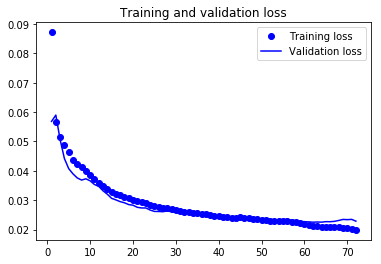

In [106]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [107]:
trained_ed_lstm_model_hs = tf.keras.models.load_model(model_path)

In [108]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))
test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))

# Inserting the model
predicted_results = trained_ed_lstm_model_hs.predict(test_scaled)
predicted_results

array([[[0.6755979 ],
        [0.63748026],
        [0.6254375 ],
        [0.6207213 ],
        [0.596212  ],
        [0.552284  ],
        [0.4978743 ],
        [0.43335313],
        [0.36414778],
        [0.30158296]]], dtype=float32)

In [109]:
predicted_inv_trans = scaler_x.inverse_transform(predicted_results[0])
predicted_inv_trans

array([[4289.2744],
       [4066.1719],
       [3995.6855],
       [3968.0815],
       [3824.629 ],
       [3567.5183],
       [3249.0583],
       [2871.4158],
       [2466.357 ],
       [2100.165 ]], dtype=float32)

In [110]:
timeseries_evaluation_metrics_func(test_data, predicted_inv_trans)

MSE is : 344900.4176156223
MAE is : 456.1672119140625
RMSE is : 587.2822299504918
MAPE is : 60.47332392177286
R2 is : 0.776085457465574



In [ ]:
rmse_ed_lstm_model_hs = np.sqrt(metrics.mean_squared_error(test_data, predicted_inv_trans))

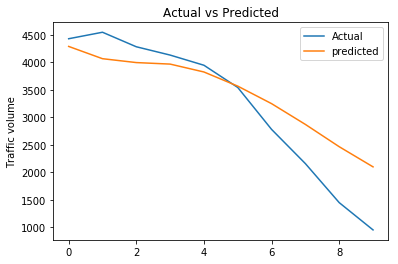

In [112]:
plt.plot(list(test_data))
plt.plot(list(predicted_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## CNN

### Single Step Style

**Define Layer Structure**

In [113]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                                 input_shape=(x_train_uni_sss.shape[1], x_train_uni_sss.shape[2])))
model.add(tf.keras.layers.MaxPool1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=horizon_sss))

model.compile(loss='mse',
              optimizer='adam')

In [114]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 30)                44190     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

**Fit the model**

In [115]:
model_path = 'model/cnn_model_sss.h5'

In [116]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [117]:
history = model.fit(train_univariate_sss, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_sss, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 2s 15ms/step - loss: 0.0834 - val_loss: 0.0210
Epoch 2/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0285 - val_loss: 0.0154
Epoch 3/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0238 - val_loss: 0.0134
Epoch 4/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0219 - val_loss: 0.0123
Epoch 5/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0202 - val_loss: 0.0119
Epoch 6/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0196 - val_loss: 0.0121
Epoch 7/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0187 - val_loss: 0.0113
Epoch 8/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0190 - val_loss: 0.0111
Epoch 9/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0181 - val_loss: 0.0104
Epoch 10/100
117/117 [==============================] - 2s 14ms/step - loss: 0.017

**Validate the model**

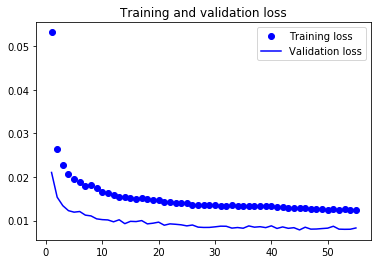

In [118]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [119]:
trained_cnn_model_sss = tf.keras.models.load_model(model_path)

In [120]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_sss)
test_history = test_horizon.values

result = []
# Define Forecast length here
window_len = len(test_data)
test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))

for i in range(1, window_len+1):
    
    test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))
    
    # Inserting the model
    predicted_results = trained_cnn_model_sss.predict(test_scaled)
    
    print(f'predicted : {predicted_results}')
    result.append(predicted_results[0])
    test_scaled = np.append(test_scaled[:,1:],[[predicted_results]])

predicted : [[0.60016906]]
predicted : [[0.5982555]]
predicted : [[0.59053373]]
predicted : [[0.6185149]]
predicted : [[0.63640904]]
predicted : [[0.67375225]]
predicted : [[0.6778408]]
predicted : [[0.64652133]]
predicted : [[0.5569166]]
predicted : [[0.46895206]]


In [121]:
result_inv_trans = scaler_x.inverse_transform(result)
result_inv_trans

array([[3847.78952348],
       [3836.58952987],
       [3791.3939414 ],
       [3955.16768301],
       [4059.90213609],
       [4278.47190922],
       [4302.40237153],
       [4119.08934379],
       [3594.63282764],
       [3079.77640569]])

In [122]:
timeseries_evaluation_metrics_func(test_data, result_inv_trans)

MSE is : 1694409.136495232
MAE is : 1056.0334316194057
RMSE is : 1301.6947170881626
MAPE is : 65.7600814585999
R2 is : -0.10003591554739999



In [123]:
rmse_cnn_model_sss = np.sqrt(metrics.mean_squared_error(test_data, result_inv_trans))

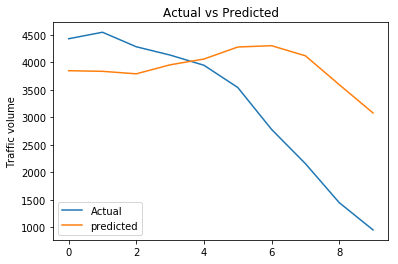

In [124]:
plt.plot(list(test_data))
plt.plot(list(result_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

### Horizon Style

**Define Layer Structure**

In [125]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                                 input_shape=(x_train_uni_hs.shape[1], x_train_uni_hs.shape[2])))
model.add(tf.keras.layers.MaxPool1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=horizon_hs))

model.compile(loss='mse',
              optimizer='adam')

In [126]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1472)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                44190     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

**Fit the model**

In [127]:
model_path = 'model/cnn_model_hs.h5'

In [128]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [129]:
history = model.fit(train_univariate_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_univariate_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 2s 14ms/step - loss: 0.1371 - val_loss: 0.0516
Epoch 2/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0659 - val_loss: 0.0430
Epoch 3/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0560 - val_loss: 0.0391
Epoch 4/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0516 - val_loss: 0.0373
Epoch 5/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0485 - val_loss: 0.0354
Epoch 6/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0464 - val_loss: 0.0347
Epoch 7/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0446 - val_loss: 0.0336
Epoch 8/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0436 - val_loss: 0.0330
Epoch 9/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0426 - val_loss: 0.0326
Epoch 10/100
117/117 [==============================] - 2s 13ms/step - loss: 0.042

**Validate the model**

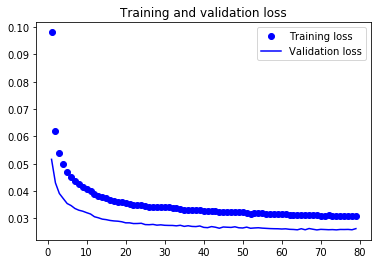

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Test the model**

In [131]:
trained_cnn_model_hs = tf.keras.models.load_model(model_path)

In [132]:
df_temp = df['traffic_volume']
test_horizon = df_temp.tail(univar_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history.reshape(-1, 1))
test_scaled = test_scaled.reshape((1, test_scaled.shape[0], 1))

# Inserting the model
predicted_results = trained_cnn_model_hs.predict(test_scaled)
predicted_results

array([[0.53445166, 0.5491122 , 0.55809206, 0.56329536, 0.569597  ,
        0.5700539 , 0.5432729 , 0.48478583, 0.42076778, 0.3820931 ]],
      dtype=float32)

In [133]:
predicted_inv_trans = scaler_x.inverse_transform(predicted_results)
predicted_inv_trans

array([[3463.1455, 3548.9536, 3601.5127, 3631.9678, 3668.8513, 3671.5254,
        3514.7764, 3172.4517, 2797.754 , 2571.3909]], dtype=float32)

In [134]:
timeseries_evaluation_metrics_func(test_data, predicted_inv_trans[0])

MSE is : 873521.9969214082
MAE is : 826.446728515625
RMSE is : 934.6239869174171
MAPE is : 41.82571522223488
R2 is : 0.43289637140307147



In [135]:
rmse_cnn_model_hs = np.sqrt(metrics.mean_squared_error(test_data, predicted_inv_trans[0]))

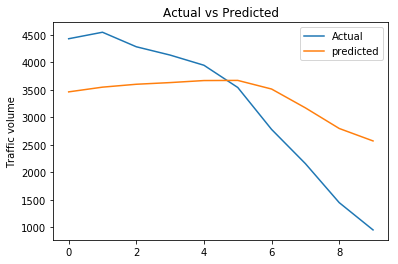

In [136]:
plt.plot(list(test_data))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

# Get the Best Model

In [137]:
column_names = ["Model", "RMSE"]
df = pd.DataFrame(columns = column_names)

rmse_lstm_model_sss_df = pd.DataFrame([('lstm_model_sss', rmse_lstm_model_sss)], columns=column_names)
df = df.append(rmse_lstm_model_sss_df)

rmse_lstm_model_hs_df = pd.DataFrame([('lstm_model_hs', rmse_lstm_model_hs)], columns=column_names)
df = df.append(rmse_lstm_model_hs_df)

rmse_bi_lstm_model_sss_df = pd.DataFrame([('bi_lstm_model_sss', rmse_bi_lstm_model_sss)], columns=column_names)
df = df.append(rmse_bi_lstm_model_sss_df)

rmse_bi_lstm_model_hs_df = pd.DataFrame([('bi_lstm_model_hs', rmse_bi_lstm_model_hs)], columns=column_names)
df = df.append(rmse_bi_lstm_model_hs_df)

rmse_gru_model_sss_df = pd.DataFrame([('gru_model_sss', rmse_gru_model_sss)], columns=column_names)
df = df.append(rmse_gru_model_sss_df)

rmse_gru_model_hs_df = pd.DataFrame([('gru_model_hs', rmse_gru_model_hs)], columns=column_names)
df = df.append(rmse_gru_model_hs_df)

rmse_ed_lstm_model_sss_df = pd.DataFrame([('ed_lstm_model_sss', rmse_ed_lstm_model_sss)], columns=column_names)
df = df.append(rmse_ed_lstm_model_sss_df)

rmse_ed_lstm_model_hs_df = pd.DataFrame([('ed_lstm_model_hs', rmse_ed_lstm_model_hs)], columns=column_names)
df = df.append(rmse_ed_lstm_model_hs_df)

rmse_cnn_model_sss_df = pd.DataFrame([('cnn_model_sss', rmse_cnn_model_sss)], columns=column_names)
df = df.append(rmse_cnn_model_sss_df)

rmse_cnn_model_hs_df = pd.DataFrame([('cnn_model_hs', rmse_cnn_model_hs)], columns=column_names)
df = df.append(rmse_cnn_model_hs_df)

df

,Model,RMSE
0,lstm_model_sss,769.024834
0,lstm_model_hs,533.328877
0,bi_lstm_model_sss,1008.544315
0,bi_lstm_model_hs,837.121518
0,gru_model_sss,1110.246466
0,gru_model_hs,639.633823
0,ed_lstm_model_sss,852.876751
0,ed_lstm_model_hs,587.282230
0,cnn_model_sss,1301.694717
0,cnn_model_hs,934.623987


In [138]:
best_model = df.sort_values(by='RMSE', ascending=True)
best_model

,Model,RMSE
0,lstm_model_hs,533.328877
0,ed_lstm_model_hs,587.282230
0,gru_model_hs,639.633823
0,lstm_model_sss,769.024834
0,bi_lstm_model_hs,837.121518
0,ed_lstm_model_sss,852.876751
0,cnn_model_hs,934.623987
0,bi_lstm_model_sss,1008.544315
0,gru_model_sss,1110.246466
0,cnn_model_sss,1301.694717
